Kitaev's vortex-full Honeycomb Model with anti-vortices

This notebook explores the eigenvalues of the Kitaev honeycomb model. 
The following steps are carried out:
1. Calculation of eigenvalues for the fortex full model.
2. Addition of two anti-vortices and study of their impact.
3. Examination of the energy splitting in the lowest energy states with respect to the Next Nearest Neighbour hopping parameter K.

## Key Steps:
- **Theory**: The Kitaev model is an exactly solvable model on a two-dimensional honeycomb lattice. In this notebook we consider the original Kitaev's model and fill it with \pi/2 flux.
- **Analysis**: The energy splitting with respect to the nearest neighbour hopping parameter gives us an indication of the topological nature of the system.

Below, the workflow includes defining the Hamiltonian, computing eigenvalues, introducing anti-vortices, 
and analyzing results.

In [1]:
import numpy as np
from scipy import linalg
from scipy import sparse
import scipy.sparse.linalg
import time
import os
import matplotlib.pyplot as plt
import cmath 
import math
from scipy import optimize
from scipy.optimize import fmin
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

### Kitaev's full-vortex model

In [16]:
#Kitaev honeycomb vortexfull
#gap found = 6*sqrt(3)
#gap vanished for kappa=0 and 0.5. It reaches 2*sqrt(3)*kappa for large kappa (try K =50)
nx = 24*2
ny = 24*2
nz=2 #0=even, 1=odd
kin = np.zeros((nx*ny*nz, nx*ny*nz), dtype=complex)
site = np.zeros((nx, ny, nz))
ste=[]
ax=[]
ay=[]
a2 = np.array([-1/2, (np.sqrt(3)/2)])
a1 = np.array([1/2, (np.sqrt(3)/2)])

J = (1)*1*1j # this is actually (i)*(2J) = J*(2)i
Jz = (1)*1*1j # this is actually (i)*(2J) = J*(2)i
K = (1)*0.05*1j

i=-1
for x in range(0,nx):
    for y in range(0,ny):
        for z in range(0,nz):
            i=i+1
            site[x,y,z]=i
            #for plotting the lattice
            a = x*a1 + y*a2 + z*((a2 + a1)/3)
            ax.append(a[0])
            ay.append(a[1])
            ste.append(int(site[x,y,z]))

for x in range(0,nx):
    for y in range(0,ny):
        i = int(site[x,y,0])
        j = int(site[x,y,1])
        # in cell 0-1
        kin[i,j] = ((-1)**x)*Jz
        kin[j,i] = ((-1)**(x+1))*Jz
        # out-cell 1-0 (right)
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        m = int(site[x1,y,0])
        kin[j,m] = -J
        kin[m,j] = J
        #NNN
        #0-0
        kin[i,m] = -((-1)**x)*K
        kin[m,i] = ((-1)**x)*K
        #1-1
        m = int(site[x1,y,1])
        kin[j,m] = -((-1)**x)*K
        kin[m,j] = ((-1)**x)*K
        # out-cell 0-1 (left)
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        m = int(site[x1,y,1])
        kin[i,m] = J
        kin[m,i] = -J
        #NNN
        #1-1
        kin[j,m] = -((-1)**x)*K
        kin[m,j] = ((-1)**x)*K
        #0-0
        m = int(site[x1,y,0])
        kin[i,m] = -((-1)**x)*K
        kin[m,i] = ((-1)**x)*K
        #####
        # out-cell 1-0 (up)
        y1 = y + 1
        if y1 > ny-1:
            y1 = 0
        m = int(site[x,y1,0])
        kin[j,m] = -J
        kin[m,j] = J
        #NNN
        #0-0
        kin[i,m] = ((-1)**x)*K
        kin[m,i] = -((-1)**x)*K
        #1-1
        m = int(site[x,y1,1])
        kin[j,m] = -((-1)**x)*K
        kin[m,j] = ((-1)**x)*K
        # out-cell 0-1 (down)
        y1 = y - 1
        if y1 < 0:
            y1 = ny-1
        m = int(site[x,y1,1])
        kin[i,m] = J
        kin[m,i] = -J
        #NNN
        #1-1
        kin[j,m] = ((-1)**x)*K
        kin[m,j] = -((-1)**x)*K
        #0-0
        m = int(site[x,y1,0])
        kin[i,m] = -((-1)**x)*K
        kin[m,i] = ((-1)**x)*K
        
        #NNN right and left
        #right 1 to 1
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        y1 = y - 1
        if y1 < 0:
            y1 = ny-1
        m = int(site[x1,y1,1])
        kin[j,m] = -K
        kin[m,j] = K
        #left 1 to 1
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        y1 = y + 1
        if y1 > ny-1:
            y1 = 0    
        m = int(site[x1,y1,1])
        kin[j,m] = K
        kin[m,j] = -K
        
        #right 0 to 0
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        y1 = y - 1
        if y1 < 0:
            y1 = ny-1
        m = int(site[x1,y1,0])
        kin[i,m] = K
        kin[m,i] = -K
        #left 0 to 0
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        y1 = y + 1
        if y1 > ny-1:
            y1 = 0    
        m = int(site[x1,y1,0])
        kin[i,m] = -K
        kin[m,i] = K

sA = sparse.csr_matrix(kin)
    
#aa1 = scipy.sparse.linalg.eigsh(sA, k=4, sigma=0, tol=1.e-10, which='SA', return_eigenvectors=True)
aa1 = scipy.sparse.linalg.eigsh(sA, k=10, sigma=0, tol=1.e-10)
#aa1 = np.linalg.eig(kin)

eigen_a1 = aa1[0]

eigenv_a1 = aa1[1]


In [17]:
eigen_a1

array([-0.08660254,  0.08660254,  0.08660254, -0.08660254,  0.08660254,
       -0.08660254, -0.1363598 , -0.1363598 ,  0.1363598 ,  0.1363598 ])

In [21]:
#Kitaev honeycomb vortexfull
#gap found = 6*sqrt(3)
#for variable Kappa/ K
nx = 60
ny = 60
nz=2 #0=even, 1=odd
kin = np.zeros((nx*ny*nz, nx*ny*nz), dtype=complex)
site = np.zeros((nx, ny, nz))
ste=[]
ax=[]
ay=[]
gap=[]
kapp=[]
a2 = np.array([-1/2, (np.sqrt(3)/2)])
a1 = np.array([1/2, (np.sqrt(3)/2)])
kappa = np.arange(0,1,0.01)

J = (1)*1*1j # this is actually (i)*(2J) = J*(2)i
Jz = (1)*1*1j # this is actually (i)*(2J) = J*(2)i
#K = (1)*0.25*1j

i=-1
for x in range(0,nx):
    for y in range(0,ny):
        for z in range(0,nz):
            i=i+1
            site[x,y,z]=i
            #for plotting the lattice
            a = x*a1 + y*a2 + z*((a2 + a1)/3)
            ax.append(a[0])
            ay.append(a[1])
            ste.append(int(site[x,y,z]))

for kapa in kappa:            
    K = (1)*kapa*1j            
    for x in range(0,nx):
        for y in range(0,ny):
            i = int(site[x,y,0])
            j = int(site[x,y,1])
            # in cell 0-1
            kin[i,j] = ((-1)**x)*Jz
            kin[j,i] = ((-1)**(x+1))*Jz
            # out-cell 1-0 (right)
            x1 = x + 1
            if x1 > nx-1:
                x1 = 0
            m = int(site[x1,y,0])
            kin[j,m] = -J
            kin[m,j] = J
            #NNN
            #0-0
            kin[i,m] = -((-1)**x)*K
            kin[m,i] = ((-1)**x)*K
            #1-1
            m = int(site[x1,y,1])
            kin[j,m] = -((-1)**x)*K
            kin[m,j] = ((-1)**x)*K
            # out-cell 0-1 (left)
            x1 = x - 1
            if x1 < 0:
                x1 = nx-1
            m = int(site[x1,y,1])
            kin[i,m] = J
            kin[m,i] = -J
            #NNN
            #1-1
            kin[j,m] = -((-1)**x)*K
            kin[m,j] = ((-1)**x)*K
            #0-0
            m = int(site[x1,y,0])
            kin[i,m] = -((-1)**x)*K
            kin[m,i] = ((-1)**x)*K
            #####
            # out-cell 1-0 (up)
            y1 = y + 1
            if y1 > ny-1:
                y1 = 0
            m = int(site[x,y1,0])
            kin[j,m] = -J
            kin[m,j] = J
            #NNN
            #0-0
            kin[i,m] = ((-1)**x)*K
            kin[m,i] = -((-1)**x)*K
            #1-1
            m = int(site[x,y1,1])
            kin[j,m] = -((-1)**x)*K
            kin[m,j] = ((-1)**x)*K
            # out-cell 0-1 (down)
            y1 = y - 1
            if y1 < 0:
                y1 = ny-1
            m = int(site[x,y1,1])
            kin[i,m] = J
            kin[m,i] = -J
            #NNN
            #1-1
            kin[j,m] = ((-1)**x)*K
            kin[m,j] = -((-1)**x)*K
            #0-0
            m = int(site[x,y1,0])
            kin[i,m] = -((-1)**x)*K
            kin[m,i] = ((-1)**x)*K
        
            #NNN right and left
            #right 1 to 1
            x1 = x + 1
            if x1 > nx-1:
                x1 = 0
            y1 = y - 1
            if y1 < 0:
                y1 = ny-1
            m = int(site[x1,y1,1])
            kin[j,m] = -K
            kin[m,j] = K
            #left 1 to 1
            x1 = x - 1
            if x1 < 0:
                x1 = nx-1
            y1 = y + 1
            if y1 > ny-1:
                y1 = 0    
            m = int(site[x1,y1,1])
            kin[j,m] = K
            kin[m,j] = -K
        
            #right 0 to 0
            x1 = x + 1
            if x1 > nx-1:
                x1 = 0
            y1 = y - 1
            if y1 < 0:
                y1 = ny-1
            m = int(site[x1,y1,0])
            kin[i,m] = K
            kin[m,i] = -K
            #left 0 to 0
            x1 = x - 1
            if x1 < 0:
                x1 = nx-1
            y1 = y + 1
            if y1 > ny-1:
                y1 = 0    
            m = int(site[x1,y1,0])
            kin[i,m] = -K
            kin[m,i] = K

    sA = sparse.csr_matrix(kin)
    
    #aa1 = scipy.sparse.linalg.eigsh(sA, k=4, sigma=0, tol=1.e-10, which='SA', return_eigenvectors=True)
    aa1 = scipy.sparse.linalg.eigsh(sA, k=1, sigma=0, tol=1.e-10)
    #aa1 = np.linalg.eig(kin)

    gap.append(2*abs(aa1[0][0]))
    kapp.append(kapa)  

Text(0, 0.5, 'gap')

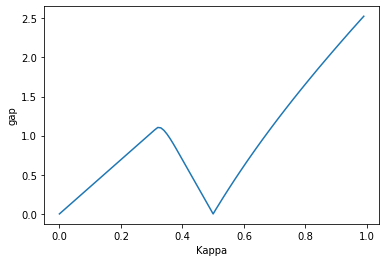

In [22]:
"""
The Kitaev's vortex full model inherently contains gap. This is a plot of the gap with respect to the next nearest neighbour hopping Kappa
"""
plt.plot(kapp,gap)
plt.xlabel('Kappa')
plt.ylabel('gap')

In [101]:
#with two antivortices of a fixed distance
#Kitaev honeycomb vortexfull
#to find the energy gap on each vortex as function of kappa
#gap found = 6*sqrt(3)
nx = 64 #(71)
ny = 64 #(71)
nz=2 #0=even, 1=odd
kin = np.zeros((nx*ny*nz, nx*ny*nz), dtype=complex)
site = np.zeros((nx, ny, nz))
kappa = np.arange(0,1,0.01)
ste=[]
ax=[]
ay=[]
sgap=[]
kapp=[]
st = 15 #start of the branch cut
d = 25
stop = st+d #end of the branch cut
#the distance between the vortices is (stop-st-1)
a2 = np.array([-1/2, (np.sqrt(3)/2)])
a1 = np.array([1/2, (np.sqrt(3)/2)])

J = (1)*1*1j # this is actually (i)*(2J) = J*(2)i
Jz = (1)*1*1j # this is actually (i)*(2J) = J*(2)i
#K = (1)*0.35*1j

i=-1
for x in range(0,nx):
    for y in range(0,ny):
        for z in range(0,nz):
            i=i+1
            site[x,y,z]=i
            #for plotting the lattice
            a = x*a1 + y*a2 + z*((a2 + a1)/3)
            ax.append(a[0])
            ay.append(a[1])
            ste.append(int(site[x,y,z]))

for kapa in kappa:            
    K = (1)*kapa*1j            
    for x in range(0,nx):
        for y in range(0,ny):
            i = int(site[x,y,0])
            j = int(site[x,y,1])
            # in cell 0-1
            kin[i,j] = ((-1)**x)*Jz
            kin[j,i] = ((-1)**(x+1))*Jz
            # out-cell 1-0 (right)
            x1 = x + 1
            if x1 > nx-1:
                x1 = 0
            m = int(site[x1,y,0])
            kin[j,m] = -J
            kin[m,j] = J
            #NNN
            #0-0
            kin[i,m] = -((-1)**x)*K
            kin[m,i] = ((-1)**x)*K
            #1-1
            m = int(site[x1,y,1])
            kin[j,m] = -((-1)**x)*K
            kin[m,j] = ((-1)**x)*K
            # out-cell 0-1 (left)
            x1 = x - 1
            if x1 < 0:
                x1 = nx-1
            m = int(site[x1,y,1])
            kin[i,m] = J
            kin[m,i] = -J
            #NNN
            #1-1
            kin[j,m] = -((-1)**x)*K
            kin[m,j] = ((-1)**x)*K
            #0-0
            m = int(site[x1,y,0])
            kin[i,m] = -((-1)**x)*K
            kin[m,i] = ((-1)**x)*K
            #####
            # out-cell 1-0 (up)
            y1 = y + 1
            if y1 > ny-1:
                y1 = 0
            m = int(site[x,y1,0])
            kin[j,m] = -J
            kin[m,j] = J
            #NNN
            #0-0
            kin[i,m] = ((-1)**x)*K
            kin[m,i] = -((-1)**x)*K
            #1-1
            m = int(site[x,y1,1])
            kin[j,m] = -((-1)**x)*K
            kin[m,j] = ((-1)**x)*K
            # out-cell 0-1 (down)
            y1 = y - 1
            if y1 < 0:
                y1 = ny-1
            m = int(site[x,y1,1])
            kin[i,m] = J
            kin[m,i] = -J
            #NNN
            #1-1
            kin[j,m] = ((-1)**x)*K
            kin[m,j] = -((-1)**x)*K
            #0-0
            m = int(site[x,y1,0])
            kin[i,m] = -((-1)**x)*K
            kin[m,i] = ((-1)**x)*K
        
            #NNN right and left
            #right 1 to 1
            x1 = x + 1
            if x1 > nx-1:
                x1 = 0
            y1 = y - 1
            if y1 < 0:
                y1 = ny-1
            m = int(site[x1,y1,1])
            kin[j,m] = -K
            kin[m,j] = K
            #left 1 to 1
            x1 = x - 1
            if x1 < 0:
                x1 = nx-1
            y1 = y + 1
            if y1 > ny-1:
                y1 = 0    
            m = int(site[x1,y1,1])
            kin[j,m] = K
            kin[m,j] = -K
        
            #right 0 to 0
            x1 = x + 1
            if x1 > nx-1:
                x1 = 0
            y1 = y - 1
            if y1 < 0:
                y1 = ny-1
            m = int(site[x1,y1,0])
            kin[i,m] = K
            kin[m,i] = -K
            #left 0 to 0
            x1 = x - 1
            if x1 < 0:
                x1 = nx-1
            y1 = y + 1
            if y1 > ny-1:
                y1 = 0    
            m = int(site[x1,y1,0])
            kin[i,m] = -K
            kin[m,i] = K
    #placing the vortices
    #remember 2J*uij, while 2K*uik*ujk (using Einstein sum conv) 
    #st+d < nx

    y2 = int(ny/2)
    for x in range(st, stop):
        i = int(site[x,y2,0])
        j = int(site[x,y2,1])
        # in cell 0-1
        kin[i,j] = -((-1)**x)*Jz #just the negative of full vortex flips
        kin[j,i] = -((-1)**(x+1))*Jz
        #add this if you want the K term in the vortex model
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        m = int(site[x1,y2,0])
        #NNN
        #0-0
        kin[i,m] = ((-1)**x)*K
        kin[m,i] = -((-1)**x)*K
        # out-cell left
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        m = int(site[x1,y2,1])
        #NNN
        #1-1
        kin[j,m] = ((-1)**x)*K
        kin[m,j] = -((-1)**x)*K
        #####
        # out-cell (up)
        y1 = y2 + 1
        m = int(site[x,y1,0])
        #NNN
        #0-0
        kin[i,m] = -((-1)**x)*K
        kin[m,i] = ((-1)**x)*K
        # out-cell (down)
        y1 = y2 - 1
        m = int(site[x,y1,1])
        #NNN
        #1-1
        kin[j,m] = -((-1)**x)*K
        kin[m,j] = ((-1)**x)*K
        #the very important step descending of y, it stays there regardless of the K term
        y2 = y2-1

    sA = sparse.csr_matrix(kin)
    aa1 = scipy.sparse.linalg.eigsh(sA, k=1, sigma=0, tol=1.e-10)
    #aa1 = np.linalg.eig(kin)
    eigen_a1 = aa1[0]
    eigenv_a1 = aa1[1]

    a2 = np.array([-1/2, (np.sqrt(3)/2)])
    a1 = np.array([1/2, (np.sqrt(3)/2)])

    sgap.append(2*abs(aa1[0][0]))
    kapp.append(kapa)  

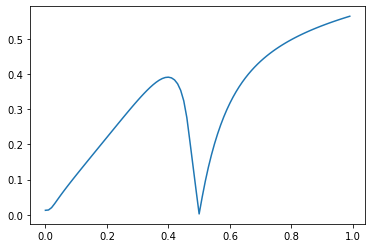

In [102]:
plt.plot(kapp,sgap)
#plt.plot(kapp,gap)
#plt.ylim(0,0.003)

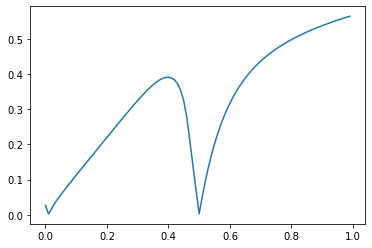

In [5]:
plt.plot(kapp,sgap)
#plt.plot(kapp,gap)
#plt.ylim(0,0.003)

In [164]:
sgap[0]

0.026839601109498085

In [10]:
"""
This section extracts the wavefunctions of the vortex full model with two anti-vortices
"""
#with two antivortices at a fixed distance
#Kitaev honeycomb vortexfull
#for the wavefunction for a fixed Kappa
#gap found = 6*sqrt(3)
#gap reaches ~ 0.7865 for large kappa
nx = 48
ny = 48
nz=2 #0=even, 1=odd
kin = np.zeros((nx*ny*nz, nx*ny*nz), dtype=complex)
site = np.zeros((nx, ny, nz))
ste=[]
ax=[]
ay=[]
dist = []
eng=[]
st = 10 #start of the branch cut
d = 20
stop = st+d #end of the branch cut
#the distance between the vortices is (stop-st-1)
a2 = np.array([-1/2, (np.sqrt(3)/2)])
a1 = np.array([1/2, (np.sqrt(3)/2)])

J = (1)*1*1j # this is actually (i)*(2J) = J*(2)i
Jz = (1)*1*1j # this is actually (i)*(2J) = J*(2)i
K = (1)*0.05*1j

i=-1
for x in range(0,nx):
    for y in range(0,ny):
        for z in range(0,nz):
            i=i+1
            site[x,y,z]=i
            #for plotting the lattice
            a = x*a1 + y*a2 + z*((a2 + a1)/3)
            ax.append(a[0])
            ay.append(a[1])
            ste.append(int(site[x,y,z]))

for x in range(0,nx):
    for y in range(0,ny):
        i = int(site[x,y,0])
        j = int(site[x,y,1])
        # in cell 0-1
        kin[i,j] = ((-1)**x)*Jz
        kin[j,i] = ((-1)**(x+1))*Jz
        # out-cell 1-0 (right)
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        m = int(site[x1,y,0])
        kin[j,m] = -J
        kin[m,j] = J
        #NNN
        #0-0
        kin[i,m] = -((-1)**x)*K
        kin[m,i] = ((-1)**x)*K
        #1-1
        m = int(site[x1,y,1])
        kin[j,m] = -((-1)**x)*K
        kin[m,j] = ((-1)**x)*K
        # out-cell 0-1 (left)
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        m = int(site[x1,y,1])
        kin[i,m] = J
        kin[m,i] = -J
        #NNN
        #1-1
        kin[j,m] = -((-1)**x)*K
        kin[m,j] = ((-1)**x)*K
        #0-0
        m = int(site[x1,y,0])
        kin[i,m] = -((-1)**x)*K
        kin[m,i] = ((-1)**x)*K
        #####
        # out-cell 1-0 (up)
        y1 = y + 1
        if y1 > ny-1:
            y1 = 0
        m = int(site[x,y1,0])
        kin[j,m] = -J
        kin[m,j] = J
        #NNN
        #0-0
        kin[i,m] = ((-1)**x)*K
        kin[m,i] = -((-1)**x)*K
        #1-1
        m = int(site[x,y1,1])
        kin[j,m] = -((-1)**x)*K
        kin[m,j] = ((-1)**x)*K
        # out-cell 0-1 (down)
        y1 = y - 1
        if y1 < 0:
            y1 = ny-1
        m = int(site[x,y1,1])
        kin[i,m] = J
        kin[m,i] = -J
        #NNN
        #1-1
        kin[j,m] = ((-1)**x)*K
        kin[m,j] = -((-1)**x)*K
        #0-0
        m = int(site[x,y1,0])
        kin[i,m] = -((-1)**x)*K
        kin[m,i] = ((-1)**x)*K
        
        #NNN right and left
        #right 1 to 1
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        y1 = y - 1
        if y1 < 0:
            y1 = ny-1
        m = int(site[x1,y1,1])
        kin[j,m] = -K
        kin[m,j] = K
        #left 1 to 1
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        y1 = y + 1
        if y1 > ny-1:
            y1 = 0    
        m = int(site[x1,y1,1])
        kin[j,m] = K
        kin[m,j] = -K
        
        #right 0 to 0
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        y1 = y - 1
        if y1 < 0:
            y1 = ny-1
        m = int(site[x1,y1,0])
        kin[i,m] = K
        kin[m,i] = -K
        #left 0 to 0
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        y1 = y + 1
        if y1 > ny-1:
            y1 = 0    
        m = int(site[x1,y1,0])
        kin[i,m] = -K
        kin[m,i] = K

#placing the vortices
#remember 2J*uij, while 2K*uik*ujk (using Einstein sum conv) 
#st+d < nx

y2 = int(ny/2)
for x in range(st, stop):
    i = int(site[x,y2,0])
    j = int(site[x,y2,1])
    # in cell 0-1
    kin[i,j] = -((-1)**x)*Jz #just the negative of full vortex flips
    kin[j,i] = -((-1)**(x+1))*Jz
    #add this if you want the K term in the vortex model
    x1 = x + 1
    if x1 > nx-1:
        x1 = 0
    m = int(site[x1,y2,0])
    #NNN
    #0-0
    kin[i,m] = ((-1)**x)*K
    kin[m,i] = -((-1)**x)*K
    # out-cell left
    x1 = x - 1
    if x1 < 0:
        x1 = nx-1
    m = int(site[x1,y2,1])
    #NNN
    #1-1
    kin[j,m] = ((-1)**x)*K
    kin[m,j] = -((-1)**x)*K
    #####
    # out-cell (up)
    y1 = y2 + 1
    m = int(site[x,y1,0])
    #NNN
    #0-0
    kin[i,m] = -((-1)**x)*K
    kin[m,i] = ((-1)**x)*K
    # out-cell (down)
    y1 = y2 - 1
    m = int(site[x,y1,1])
    #NNN
    #1-1
    kin[j,m] = -((-1)**x)*K
    kin[m,j] = ((-1)**x)*K
    #the very important step descending of y, it stays there regardless of the K term
    y2 = y2-1


sA = sparse.csr_matrix(kin)
aa1 = scipy.sparse.linalg.eigsh(sA, k=4, sigma=0, tol=1.e-10)
#aa1 = np.linalg.eig(kin)
eigen_a1 = aa1[0]
eigenv_a1 = aa1[1]
eng.append(eigen_a1)

a2 = np.array([-1/2, (np.sqrt(3)/2)])
a1 = np.array([1/2, (np.sqrt(3)/2)])

xd = []
xlt = []
xlte=[]
evd = []
evd1 = []
evd2 = []
evd3 = []
evr=[]
y2 = int(ny/2)+5
for x in range(st-5,stop+5):
    evd.append(abs(eigenv_a1[int(site[x,y2,1])][0]))
    evd1.append(abs(eigenv_a1[int(site[x,y2,1])][0]))
    evd2.append(abs(eigenv_a1[int(site[x,y2,1])][0]))
    evd3.append(abs(eigenv_a1[int(site[x,y2,1])][0]))
    evr.append((eigenv_a1[int(site[x,y2,1])][0]+np.conj(eigenv_a1[int(site[x,y2,1])][0]))/np.sqrt(2))
    xd.append(x)
    xlt.append(x-(st)+0.5)
    #xlte.append(np.sqrt((x-(st)+0.5)**2+(1/(2*np.sqrt(3)))**2))
    a = x*a1 + y*a2 + z*((a2 + a1)/3)
    y2 = y2-1

In [11]:
eigen_a1

array([ 0.02690238,  0.03026463, -0.02690238, -0.03026463])

In [12]:
eigenv_a1[:,0]

array([ 0.00240792+4.18675061e-03j,  0.00330362+8.04556395e-04j,
       -0.00059842-4.27969534e-04j, ..., -0.0025523 +3.25846668e-03j,
       -0.00030081-8.07946110e-05j, -0.00368422+6.50187279e-04j])

In [21]:
eigenv_a1[:,2]

array([ 0.00333976-3.48897829e-03j,  0.00340017+9.28841325e-06j,
       -0.00068344+2.72350181e-04j, ..., -0.00169849-3.77451469e-03j,
       -0.0003114 +6.47143137e-06j, -0.00342163-1.51284222e-03j])

Text(0, 0.5, 'real part of the wave function')

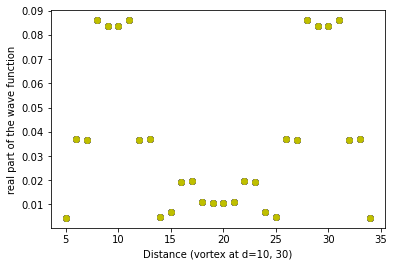

In [17]:
plt.scatter(xd, evd, color = 'r')
plt.scatter(xd, evd1, color = 'g' )
plt.scatter(xd, evd2, color = 'b')
plt.scatter(xd, evd2, color = 'y')
#plt.xlim(12,17)
plt.xlabel('Distance (vortex at d=10, 30)')
plt.ylabel('real part of the wave function')

In [ ]:
plt.scatter(xd, evd)

In [10]:
48*48*2

4608

In [183]:
"""
This is to plot the gap as a function of distance between the anti-vortices
"""
###Gap as a function of distance
#Kitaev honeycomb vortexfull
#to find the energy gap on each vortex as function of kappa
#gap found = 6*sqrt(3)
nx = 90
ny = 90
nz=2 #0=even, 1=odd
kin = np.zeros((nx*ny*nz, nx*ny*nz), dtype=complex)
site = np.zeros((nx, ny, nz))
#kappa = np.arange(0,1,0.01)
ste=[]
ax=[]
ay=[]
sgap=[]
kapp=[]
avg = []
diff = []
high = []
low = []
st = 15 #start of the branch cut
ds = 55 #maximum distance between the vortices = dist+1, d runs from 1 to dist with an interval of 1
#the distance between the vortices is (stop-st-1)
a2 = np.array([-1/2, (np.sqrt(3)/2)])
a1 = np.array([1/2, (np.sqrt(3)/2)])
dist=[]
eng=[]
eng1=[]

J = (1)*1*1j # this is actually (i)*(2J) = J*(2)i
Jz = (1)*1*1j # this is actually (i)*(2J) = J*(2)i
K = (1)*0.03*1j

i=-1
for x in range(0,nx):
    for y in range(0,ny):
        for z in range(0,nz):
            i=i+1
            site[x,y,z]=i
            #for plotting the lattice
            a = x*a1 + y*a2 + z*((a2 + a1)/3)
            ax.append(a[0])
            ay.append(a[1])
            ste.append(int(site[x,y,z]))

for x in range(0,nx):
    for y in range(0,ny):
        i = int(site[x,y,0])
        j = int(site[x,y,1])
        # in cell 0-1
        kin[i,j] = ((-1)**x)*Jz
        kin[j,i] = ((-1)**(x+1))*Jz
        # out-cell 1-0 (right)
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        m = int(site[x1,y,0])
        kin[j,m] = -J
        kin[m,j] = J
        #NNN
        #0-0
        kin[i,m] = -((-1)**x)*K
        kin[m,i] = ((-1)**x)*K
        #1-1
        m = int(site[x1,y,1])
        kin[j,m] = -((-1)**x)*K
        kin[m,j] = ((-1)**x)*K
        # out-cell 0-1 (left)
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        m = int(site[x1,y,1])
        kin[i,m] = J
        kin[m,i] = -J
        #NNN
        #1-1
        kin[j,m] = -((-1)**x)*K
        kin[m,j] = ((-1)**x)*K
        #0-0
        m = int(site[x1,y,0])
        kin[i,m] = -((-1)**x)*K
        kin[m,i] = ((-1)**x)*K
        #####
        # out-cell 1-0 (up)
        y1 = y + 1
        if y1 > ny-1:
            y1 = 0
        m = int(site[x,y1,0])
        kin[j,m] = -J
        kin[m,j] = J
        #NNN
        #0-0
        kin[i,m] = ((-1)**x)*K
        kin[m,i] = -((-1)**x)*K
        #1-1
        m = int(site[x,y1,1])
        kin[j,m] = -((-1)**x)*K
        kin[m,j] = ((-1)**x)*K
        # out-cell 0-1 (down)
        y1 = y - 1
        if y1 < 0:
            y1 = ny-1
        m = int(site[x,y1,1])
        kin[i,m] = J
        kin[m,i] = -J
        #NNN
        #1-1
        kin[j,m] = ((-1)**x)*K
        kin[m,j] = -((-1)**x)*K
        #0-0
        m = int(site[x,y1,0])
        kin[i,m] = -((-1)**x)*K
        kin[m,i] = ((-1)**x)*K
        
        #NNN right and left
        #right 1 to 1
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        y1 = y - 1
        if y1 < 0:
            y1 = ny-1
        m = int(site[x1,y1,1])
        kin[j,m] = -K
        kin[m,j] = K
        #left 1 to 1
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        y1 = y + 1
        if y1 > ny-1:
            y1 = 0    
        m = int(site[x1,y1,1])
        kin[j,m] = K
        kin[m,j] = -K
        
        #right 0 to 0
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        y1 = y - 1
        if y1 < 0:
            y1 = ny-1
        m = int(site[x1,y1,0])
        kin[i,m] = K
        kin[m,i] = -K
        #left 0 to 0
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        y1 = y + 1
        if y1 > ny-1:
            y1 = 0    
        m = int(site[x1,y1,0])
        kin[i,m] = -K
        kin[m,i] = K
            
#placing the vortices
#remember 2J*uij, while 2K*uik*ujk (using Einstein sum conv) 
#st+d < nx
for d in range(1,ds):
    y2 = int(ny/2)
    for x in range(st, st+d):
        i = int(site[x,y2,0])
        j = int(site[x,y2,1])
        # in cell 0-1
        kin[i,j] = -((-1)**x)*Jz #just the negative of full vortex flips
        kin[j,i] = -((-1)**(x+1))*Jz
        #add this if you want the K term in the vortex model
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        m = int(site[x1,y2,0])
        #NNN
        #0-0
        kin[i,m] = ((-1)**x)*K
        kin[m,i] = -((-1)**x)*K
        # out-cell left
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        m = int(site[x1,y2,1])
        #NNN
        #1-1
        kin[j,m] = ((-1)**x)*K
        kin[m,j] = -((-1)**x)*K
        #####
        # out-cell (up)
        y1 = y2 + 1
        m = int(site[x,y1,0])
        #NNN
        #0-0
        kin[i,m] = -((-1)**x)*K
        kin[m,i] = ((-1)**x)*K
        # out-cell (down)
        y1 = y2 - 1
        m = int(site[x,y1,1])
        #NNN
        #1-1
        kin[j,m] = -((-1)**x)*K
        kin[m,j] = ((-1)**x)*K
        #the very important step descending of y, it stays there regardless of the K term
        y2 = y2-1

    sA = sparse.csr_matrix(kin)
    aa1 = scipy.sparse.linalg.eigsh(sA, k=2, sigma=0, tol=1.e-10, which='SA')
    #aa1 = np.linalg.eig(kin)
    eigen_a1 = abs(aa1[0])
    eigen_a2 = abs(aa1[1])
    eigenv_a1 = aa1[1]
    avg.append((eigen_a1[0]+eigen_a1[1])/2)
    diff.append(abs(eigen_a1[0]-eigen_a1[1]))
    dist.append(d)
    eng.append(eigen_a1)
    high.append(abs(eigen_a1[0]))
    low.append(abs(eigen_a1[1]))

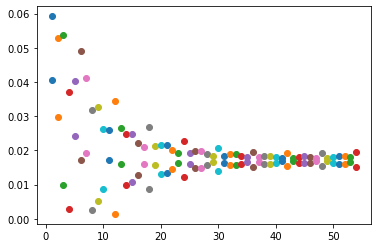

In [184]:
for p,q in zip(dist, eng):
    plt.scatter([p]*len(q),q)
#plt.xlim(0, 8) 
#plt.ylim(-0.20, -0.025) 

(0.0, 0.07)

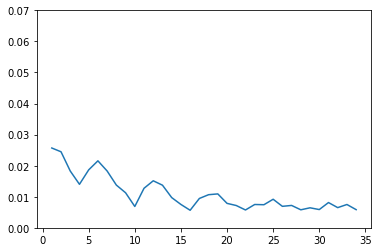

In [161]:
plt.plot(dist,avg)
plt.ylim(0,0.07)

In [185]:
avg

[0.04987382880451964,
 0.0413252888446631,
 0.031816107998839334,
 0.019926794192452624,
 0.03217981174197587,
 0.033152728452625624,
 0.03016062624241342,
 0.017204292154117437,
 0.01891381402336778,
 0.0174439395612742,
 0.021539924026098653,
 0.017936623881621507,
 0.02120849364704821,
 0.0173861931501349,
 0.01784167302838229,
 0.017372988732629865,
 0.018624262664956467,
 0.01771104957885758,
 0.01855827509385377,
 0.017342592696945845,
 0.01748839872476172,
 0.01731339685766885,
 0.017732898542535805,
 0.017496780866161382,
 0.01772035458730245,
 0.017300892131243334,
 0.01735400645659017,
 0.017281607988101667,
 0.01743905155435011,
 0.01738167085967034,
 0.017437205500261427,
 0.017276933008410534,
 0.017299951060946,
 0.017266745213127377,
 0.017337991750716437,
 0.01732735543632262,
 0.01733795115231481,
 0.017265146778282295,
 0.01727873843187733,
 0.017260924289999167,
 0.017305784714355368,
 0.01730621778450131,
 0.01730584878588444,
 0.01726054798255512,
 0.01727313529004

In [186]:
def td(e1,e2):
    return np.sqrt(e1**2+e2**2-0.017327355436322557**2)
ha = np.array(high)
lw = np.array(low)
td1 = td(ha,lw)

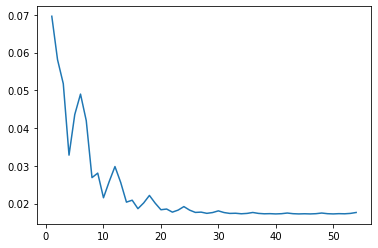

In [188]:
plt.plot(dist,td1)

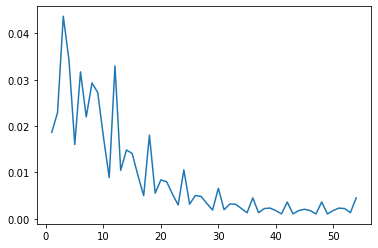

In [189]:
plt.plot(dist,diff)

In [130]:
#with two antivortices at a fixed distance
#Kitaev honeycomb vortexfull
#for the wavefunction for a fixed Kappa
#gap found = 6*sqrt(3)
#gap reaches ~ 0.7865 for large kappa
nx = 12
ny = 12
nz=2 #0=even, 1=odd
kin = np.zeros((nx*ny*nz, nx*ny*nz), dtype=complex)
site = np.zeros((nx, ny, nz))
ste=[]
ax=[]
ay=[]
dist = []
eng=[]
st = 2 #start of the branch cut
d = 6
stop = st+d #end of the branch cut
#the distance between the vortices is (stop-st-1)
a2 = np.array([-1/2, (np.sqrt(3)/2)])
a1 = np.array([1/2, (np.sqrt(3)/2)])

J = (1)*1*1j # this is actually (i)*(2J) = J*(2)i
Jz = (1)*1*1j # this is actually (i)*(2J) = J*(2)i
K = (1)*0.25*1j

i=-1
for x in range(0,nx):
    for y in range(0,ny):
        for z in range(0,nz):
            i=i+1
            site[x,y,z]=i
            #for plotting the lattice
            a = x*a1 + y*a2 + z*((a2 + a1)/3)
            ax.append(a[0])
            ay.append(a[1])
            ste.append(int(site[x,y,z]))

for x in range(0,nx):
    for y in range(0,ny):
        i = int(site[x,y,0])
        j = int(site[x,y,1])
        # in cell 0-1
        kin[i,j] = ((-1)**x)*Jz
        kin[j,i] = ((-1)**(x+1))*Jz
        # out-cell 1-0 (right)
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        m = int(site[x1,y,0])
        kin[j,m] = -J
        kin[m,j] = J
        #NNN
        #0-0
        kin[i,m] = -((-1)**x)*K
        kin[m,i] = ((-1)**x)*K
        #1-1
        m = int(site[x1,y,1])
        kin[j,m] = -((-1)**x)*K
        kin[m,j] = ((-1)**x)*K
        # out-cell 0-1 (left)
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        m = int(site[x1,y,1])
        kin[i,m] = J
        kin[m,i] = -J
        #NNN
        #1-1
        kin[j,m] = -((-1)**x)*K
        kin[m,j] = ((-1)**x)*K
        #0-0
        m = int(site[x1,y,0])
        kin[i,m] = -((-1)**x)*K
        kin[m,i] = ((-1)**x)*K
        #####
        # out-cell 1-0 (up)
        y1 = y + 1
        if y1 > ny-1:
            y1 = 0
        m = int(site[x,y1,0])
        kin[j,m] = -J
        kin[m,j] = J
        #NNN
        #0-0
        kin[i,m] = ((-1)**x)*K
        kin[m,i] = -((-1)**x)*K
        #1-1
        m = int(site[x,y1,1])
        kin[j,m] = -((-1)**x)*K
        kin[m,j] = ((-1)**x)*K
        # out-cell 0-1 (down)
        y1 = y - 1
        if y1 < 0:
            y1 = ny-1
        m = int(site[x,y1,1])
        kin[i,m] = J
        kin[m,i] = -J
        #NNN
        #1-1
        kin[j,m] = ((-1)**x)*K
        kin[m,j] = -((-1)**x)*K
        #0-0
        m = int(site[x,y1,0])
        kin[i,m] = -((-1)**x)*K
        kin[m,i] = ((-1)**x)*K
        
        #NNN right and left
        #right 1 to 1
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        y1 = y - 1
        if y1 < 0:
            y1 = ny-1
        m = int(site[x1,y1,1])
        kin[j,m] = -K
        kin[m,j] = K
        #left 1 to 1
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        y1 = y + 1
        if y1 > ny-1:
            y1 = 0    
        m = int(site[x1,y1,1])
        kin[j,m] = K
        kin[m,j] = -K
        
        #right 0 to 0
        x1 = x + 1
        if x1 > nx-1:
            x1 = 0
        y1 = y - 1
        if y1 < 0:
            y1 = ny-1
        m = int(site[x1,y1,0])
        kin[i,m] = K
        kin[m,i] = -K
        #left 0 to 0
        x1 = x - 1
        if x1 < 0:
            x1 = nx-1
        y1 = y + 1
        if y1 > ny-1:
            y1 = 0    
        m = int(site[x1,y1,0])
        kin[i,m] = -K
        kin[m,i] = K

#placing the vortices
#remember 2J*uij, while 2K*uik*ujk (using Einstein sum conv) 
#st+d < nx

y2 = int(ny/2)
for x in range(st, stop):
    i = int(site[x,y2,0])
    j = int(site[x,y2,1])
    # in cell 0-1
    kin[i,j] = -((-1)**x)*Jz #just the negative of full vortex flips
    kin[j,i] = -((-1)**(x+1))*Jz

    #the very important step descending of y, it stays there regardless of the K term
    y2 = y2-1


sA = sparse.csr_matrix(kin)
aa1 = scipy.sparse.linalg.eigsh(sA, k=4, sigma=0, tol=1.e-10)
#aa1 = np.linalg.eig(kin)
eigen_a1 = aa1[0]
eigenv_a1 = aa1[1]
eng.append(eigen_a1)


In [131]:
eigen_a1

array([ 9.93065972e-05, -9.93065972e-05,  5.57007190e-03, -5.57007190e-03])

In [ ]:
    #add this if you want the K term in the vortex model
    x1 = x + 1
    if x1 > nx-1:
        x1 = 0
    m = int(site[x1,y2,0])
    #NNN
    #0-0
    kin[i,m] = ((-1)**x)*K
    kin[m,i] = -((-1)**x)*K
    # out-cell left
    x1 = x - 1
    if x1 < 0:
        x1 = nx-1
    m = int(site[x1,y2,1])
    #NNN
    #1-1
    kin[j,m] = ((-1)**x)*K
    kin[m,j] = -((-1)**x)*K
    #####
    # out-cell (up)
    y1 = y2 + 1
    m = int(site[x,y1,0])
    #NNN
    #0-0
    kin[i,m] = -((-1)**x)*K
    kin[m,i] = ((-1)**x)*K
    # out-cell (down)
    y1 = y2 - 1
    m = int(site[x,y1,1])
    #NNN
    #1-1
    kin[j,m] = -((-1)**x)*K
    kin[m,j] = ((-1)**x)*K
    #the very important step descending of y, it stays there regardless of the K term
    y2 = y2-1